In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39835")
client

<Client: 'tcp://127.0.0.1:39835' processes=10 threads=50, memory=196.70 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from xhistogram.xarray import histogram as xhist
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

xchunk = 100
ychunk = 100

nmembs = np.arange(100,148)

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,dd:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
dsg = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                              % (100)), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).chunk({'YC':ychunk,'YG':ychunk,
                              'XC':xchunk,'XG':xchunk})
grid = Grid(dsg, periodic=['X'])
Vol = (dsg.rA * dsg.drF * dsg.hFacC).where(dsg.maskC!=0.)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center

In [7]:
ds0 = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/wb.zarr' 
                           % (years[0],ntimes[0,0])))
ds1 = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/Div_vh.zarr' 
                          % (years[yystart],ntimes[0,0])))
ds2 = xr.open_zarr(op.join(savedir,'%4d/%010d/GradH.zarr' 
                           % (years[0],ntimes[0,0])))

In [8]:
res = (ds0.wb - ds1.Gh).reset_coords(drop=True)
res.name = 'Residual'

In [9]:
# wb = ds0.wb
# wb.name = 'wb'
H_ = ds2.H_.reset_coords(drop=True)
H_.name = 'H_'

In [11]:
histo = xhist(H_, 
              res,
              bins=[np.concatenate((-np.logspace(-6,-9,15),
                                    np.concatenate((np.linspace(-9e-10,9e-10,11),
                                                    np.logspace(-9,-6,15))))), 
                    np.concatenate((-np.logspace(-6,-9,15),
                                    np.concatenate((np.linspace(-9e-10,9e-10,11),
                                                    np.logspace(-9,-6,15)))))
                   ]
     ).compute()

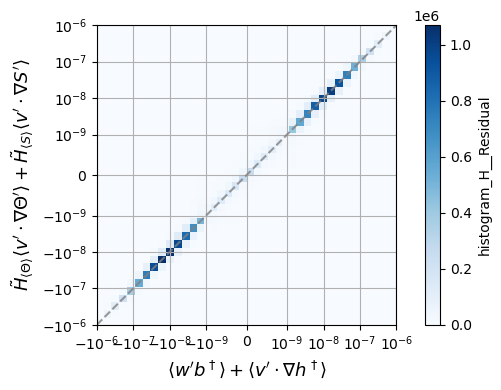

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

histo.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(-1e-6,1e-6), np.linspace(-1e-6,1e-6), c='grey', ls='--', alpha=.8)
# ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-9)
ax.set_yscale('symlog', linthresh=1e-9)
ax.set_ylim([-1e-6,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_ylabel(r"$\tilde{H}_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + \tilde{H}_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle$", 
              fontsize=13)
ax.set_xlabel(r"$\langle w'b^\dagger\rangle + \langle v'\cdot\nabla h^\dagger\rangle$", fontsize=13)

ax.grid(True)
ax.set_aspect('equal')

plt.savefig(op.join(savedir,'Figures/Histo_wb_recon_%010d.pdf' % ntimes[0,0]))

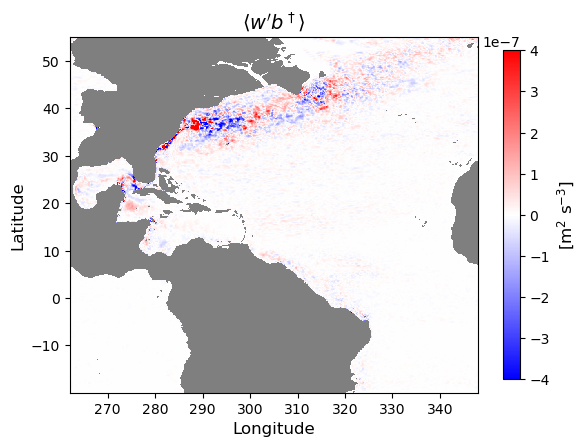

In [20]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, ds0.wb.isel(Z=15),
                   vmin=-4e-7, vmax=4e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w'b^\dagger\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/wpbp_%010d.pdf' % ntimes[0,0]))

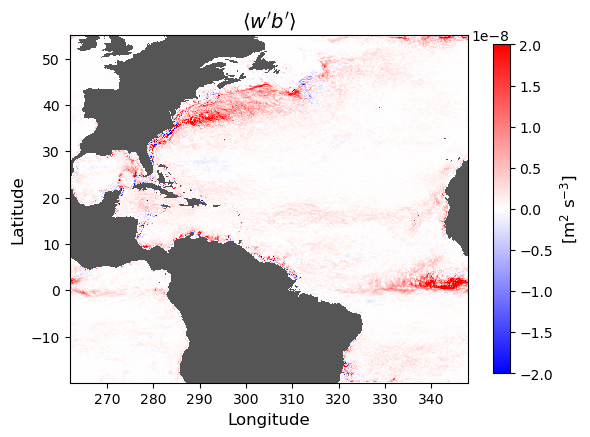

In [9]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, ds0.wb.sel(Z=8e2,method='nearest'),
                   vmin=-2e-8, vmax=2e-8, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).sel(Z=800,method='nearest'),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w'b'\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/wpbp_Z800_%010d.pdf' % ntimes[0,0]))

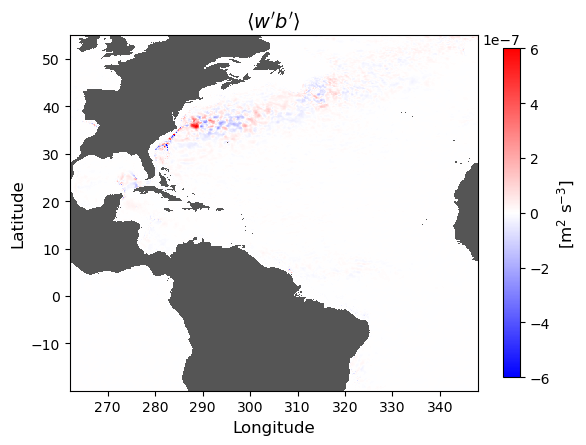

In [51]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, 
                   ((ds0.wb*dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
                    * 1e-3),
                   vmin=-6e-7, vmax=6e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w'b'\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/wpbp_Z1000ave_%010d.pdf' % ntimes[0,0]))

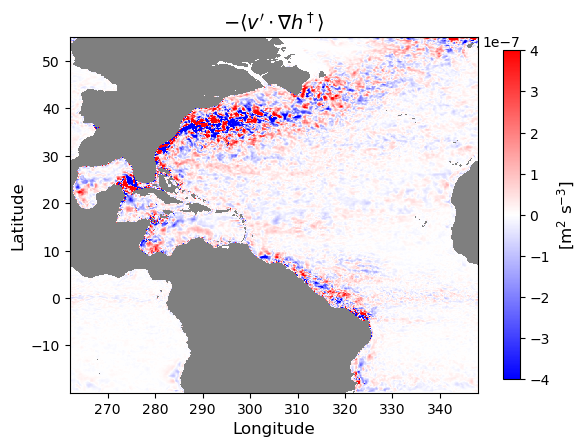

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, ds1.Gh.isel(Z=15),
                   vmin=-4e-7, vmax=4e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(r"$-\langle v'\cdot \nabla h^\dagger\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/vDivh_%010d.pdf' % ntimes[0,0]))

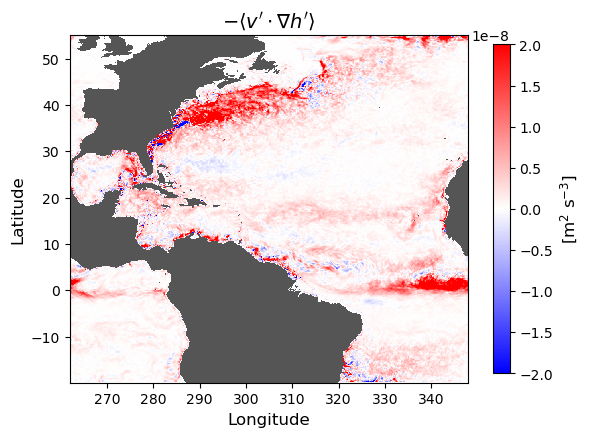

In [10]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, ds1.Gh.sel(Z=8e2,method='nearest'),
                   vmin=-2e-8, vmax=2e-8, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).sel(Z=800,method='nearest'),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$-\langle v'\cdot \nabla h'\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/vDivh_Z800_%010d.pdf' % ntimes[0,0]))

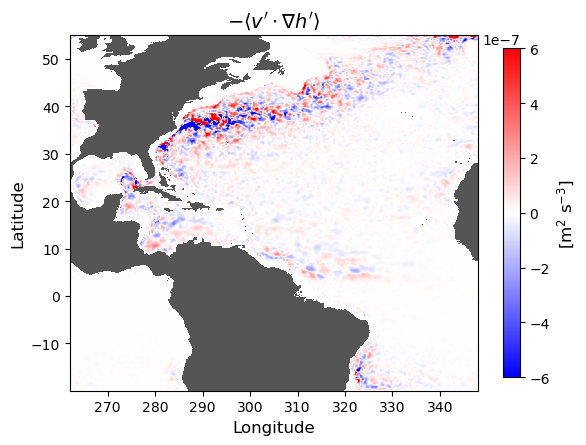

In [52]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC,
                   ((ds1.Gh*dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
                    * 1e-3),
                   vmin=-6e-7, vmax=6e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$-\langle v'\cdot \nabla h'\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/vDivh_Z1000ave_%010d.pdf' % ntimes[0,0]))

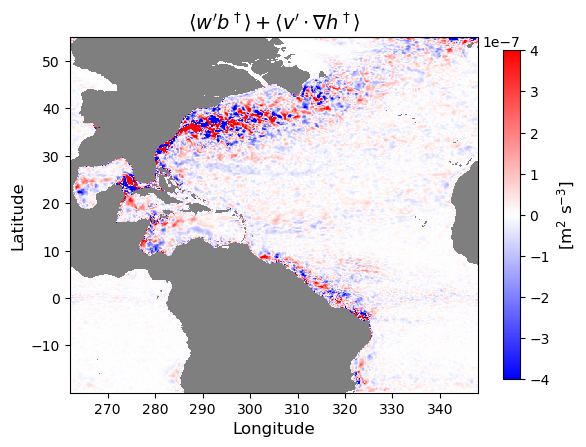

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, res.isel(Z=15),
                   vmin=-4e-7, vmax=4e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w'b^\dagger\rangle+\langle v'\cdot \nabla h^\dagger\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/wb-vDivh_%010d.pdf' % ntimes[0,0]))

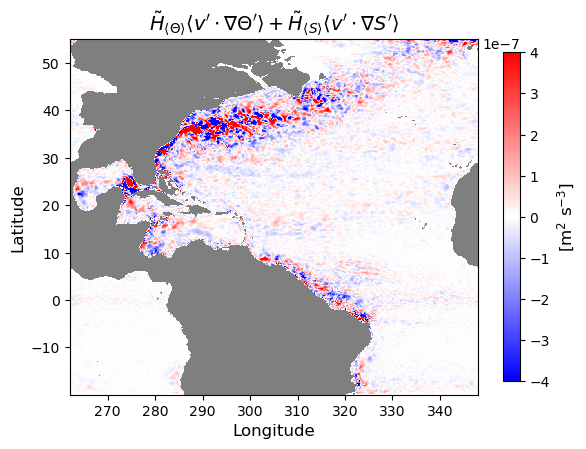

In [18]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, H_.isel(Z=15),
                   vmin=-4e-7, vmax=4e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(r"$\tilde{H}_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + \tilde{H}_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/gradH_%010d.pdf' % ntimes[0,0]))

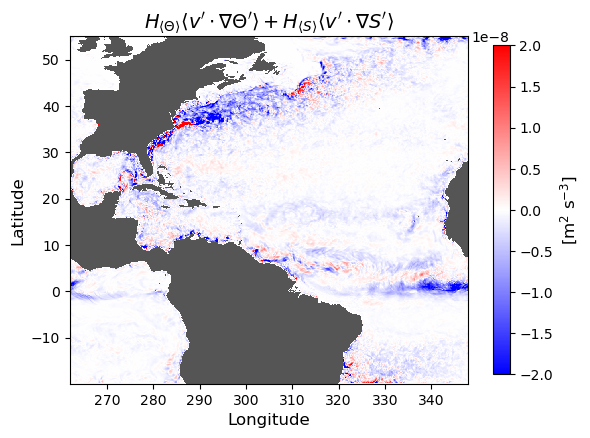

In [11]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, ds2.H_.sel(Z=8e2,method='nearest'),
                   vmin=-2e-8, vmax=2e-8, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).sel(Z=800,method='nearest'),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$H_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + H_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/gradH_Z800_%010d.pdf' % ntimes[0,0]))

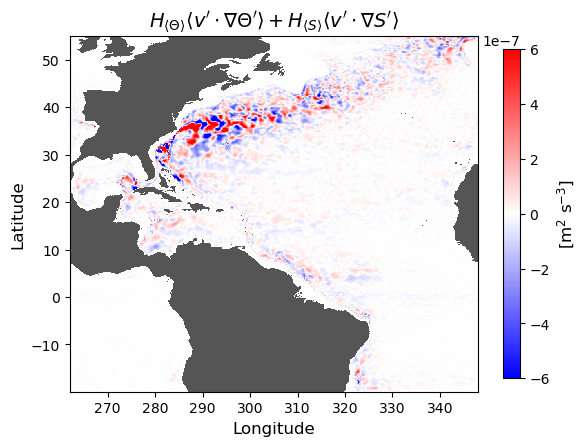

In [53]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, 
                   ((ds2.H_*dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
                    * 1e-3),
                   vmin=-6e-7, vmax=6e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$H_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + H_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/gradH_Z1000ave_%010d.pdf' % ntimes[0,0]))

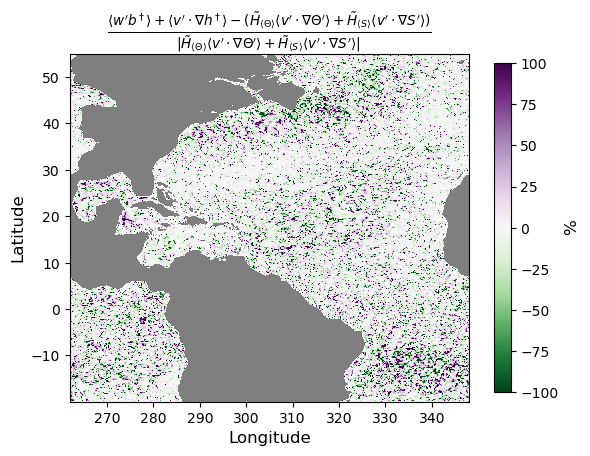

In [19]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, 
                   ((res - H_) / np.abs(H_)*1e2).isel(Z=15),
                   vmin=-100, vmax=100, cmap='PRGn_r', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(
    r"$\frac{\langle w'b^\dagger\rangle + \langle v'\cdot \nabla h^\dagger\rangle - (\tilde{H}_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + \tilde{H}_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle)}{|\tilde{H}_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + \tilde{H}_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle|}$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"$\%$", fontsize=12)
plt.savefig(op.join(savedir,'Figures/PER_Dk-res_%010d.pdf' % ntimes[0,0]))

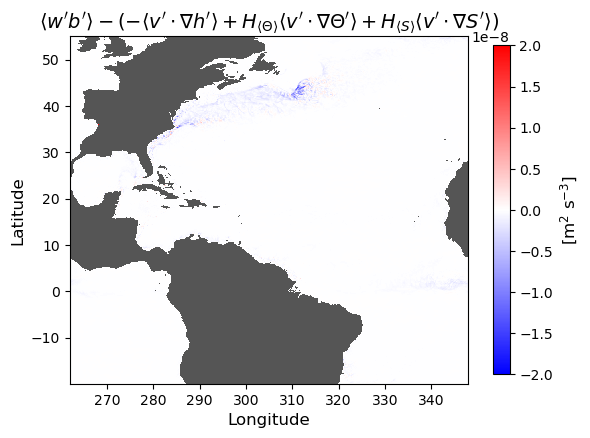

In [12]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, (res-ds2.H_).sel(Z=8e2,method='nearest'),
                   vmin=-2e-8, vmax=2e-8, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).sel(Z=800,method='nearest'),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w'b'\rangle -(-\langle v'\cdot \nabla h'\rangle +$" 
    + r"$H_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + H_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle)$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/Dk-res_Z800_%010d.pdf' % ntimes[0,0]))

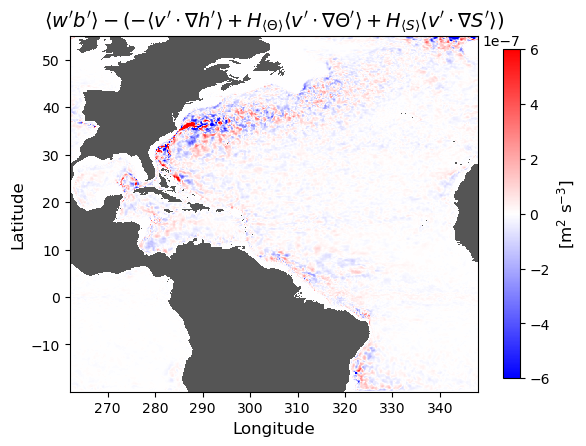

In [54]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(ds0.XC, ds0.YC, 
                   (((res-ds2.H_)*dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
                    * 1e-3),
                   vmin=-6e-7, vmax=6e-7, cmap='bwr', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w'b'\rangle -(-\langle v'\cdot \nabla h'\rangle + H_{\langle\Theta\rangle}\langle v'\cdot \nabla \Theta'\rangle + H_{\langle S\rangle}\langle v'\cdot \nabla S'\rangle)$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/Dk-res_Z1000ave_%010d.pdf' % ntimes[0,0]))

In [24]:
from datetime import timedelta
time = np.arange('1967-01-01', '1968-01-01', timedelta(days=5), dtype='datetime64[D]')
time

array(['1967-01-01', '1967-01-06', '1967-01-11', '1967-01-16',
       '1967-01-21', '1967-01-26', '1967-01-31', '1967-02-05',
       '1967-02-10', '1967-02-15', '1967-02-20', '1967-02-25',
       '1967-03-02', '1967-03-07', '1967-03-12', '1967-03-17',
       '1967-03-22', '1967-03-27', '1967-04-01', '1967-04-06',
       '1967-04-11', '1967-04-16', '1967-04-21', '1967-04-26',
       '1967-05-01', '1967-05-06', '1967-05-11', '1967-05-16',
       '1967-05-21', '1967-05-26', '1967-05-31', '1967-06-05',
       '1967-06-10', '1967-06-15', '1967-06-20', '1967-06-25',
       '1967-06-30', '1967-07-05', '1967-07-10', '1967-07-15',
       '1967-07-20', '1967-07-25', '1967-07-30', '1967-08-04',
       '1967-08-09', '1967-08-14', '1967-08-19', '1967-08-24',
       '1967-08-29', '1967-09-03', '1967-09-08', '1967-09-13',
       '1967-09-18', '1967-09-23', '1967-09-28', '1967-10-03',
       '1967-10-08', '1967-10-13', '1967-10-18', '1967-10-23',
       '1967-10-28', '1967-11-02', '1967-11-07', '1967-

In [61]:
dse = xr.open_zarr(op.join(savedir,'%4d/KE_VolAve.zarr' 
                           % (years[0])))
dsh = xr.open_zarr(op.join(savedir,'%4d/H_VolAve.zarr' 
                           % (years[0])))
dswb = xr.open_zarr(op.join(savedir,'%4d/wpbp_VolAve.zarr' 
                            % (years[0])))
dsH_ = xr.open_zarr(op.join(savedir,'%4d/GradH_VolAve.zarr' 
                            % (years[0])))
dsWB = xr.open_zarr(op.join(savedir,'%4d/WB_VolAve.zarr' 
                            % (years[0])))
dsk = xr.open_zarr(op.join(savedir,'%4d/K-k_VolAve.zarr' 
                           % (years[0])))
dss = xr.open_zarr(op.join(savedir,'%4d/S-P_VolAve.zarr' 
                           % (years[0])))
dst = xr.open_zarr(op.join(savedir,'%4d/EKETEND_VolAve.zarr' 
                           % (years[0])))
dsT = xr.open_zarr(op.join(savedir,'%4d/MKETEND_VolAve.zarr' 
                           % (years[0])))
dsd = xr.open_zarr(op.join(savedir,'%4d/EKEDISS_VolAve.zarr' 
                           % (years[0])))
dsD = xr.open_zarr(op.join(savedir,'%4d/MKEDISS_VolAve.zarr' 
                           % (years[0])))
dsa = xr.open_zarr(op.join(savedir,'%4d/EKEADV_VolAve.zarr' 
                           % (years[0])))
dsA = xr.open_zarr(op.join(savedir,'%4d/MKEADV_VolAve.zarr' 
                           % (years[0])))
dsV = xr.open_zarr(op.join(savedir,'%4d/MKEDISV_VolAve.zarr' 
                           % (years[0])))
dsf = xr.open_zarr(op.join(savedir,'%4d/EKEFORC_VolAve.zarr' 
                           % (years[0])))
dsF = xr.open_zarr(op.join(savedir,'%4d/MKEFORC_VolAve.zarr' 
                           % (years[0])))
dsa

<xarray.Dataset>
Dimensions:  (time: 73)
Dimensions without coordinates: time
Data variables:
    advec    (time) float32 dask.array<chunksize=(73,), meta=np.ndarray>

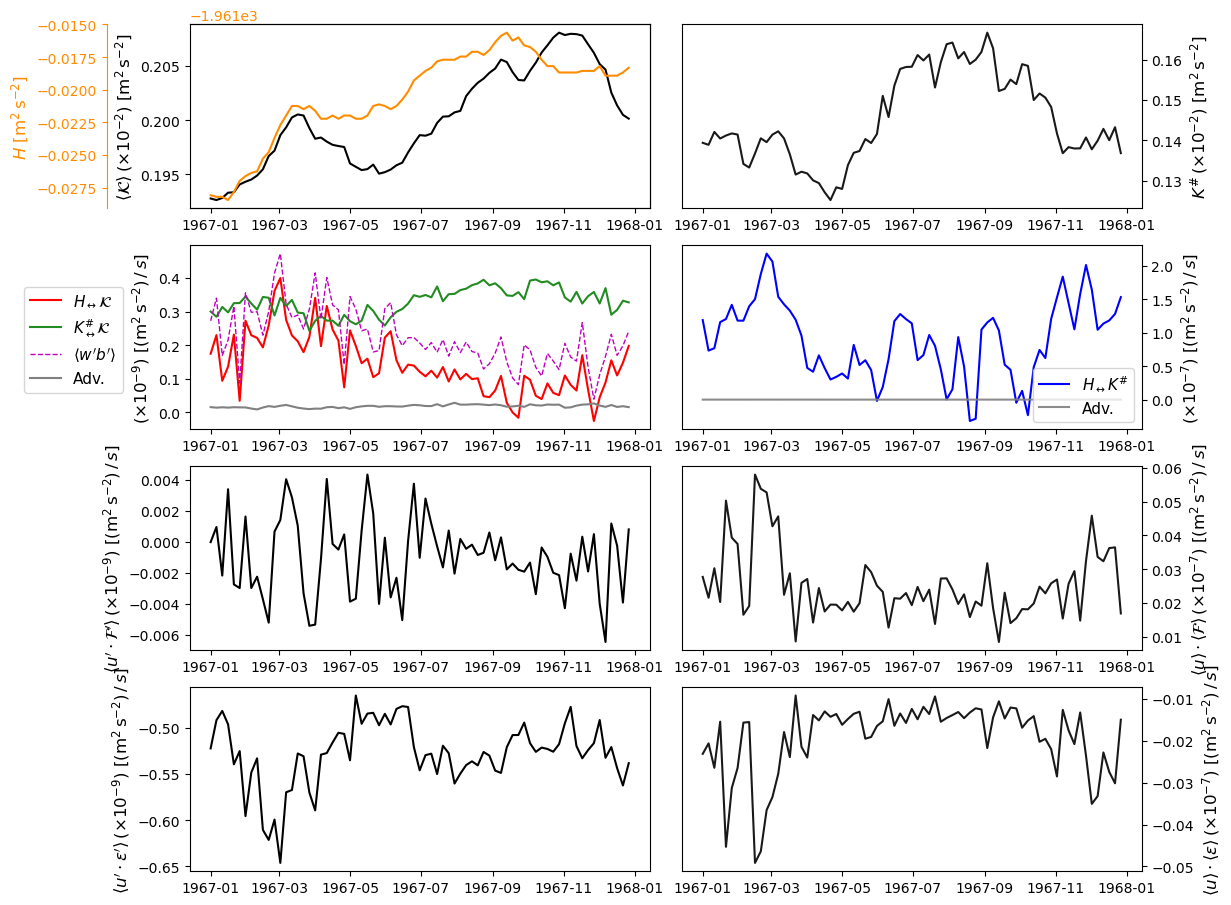

In [62]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(17,11))
# fig.set_tight_layout(True)
ax1 = axes[0,0]
ax3 = axes[1,0]
ax5 = axes[2,0]
ax7 = axes[3,0]
ax11 = ax1.twinx()
ax2 = axes[0,1]
ax4 = axes[1,1]
ax6 = axes[2,1]
ax8 = axes[3,1]
# ax2 = ax1.twinx()
# ax4 = ax3.twinx()
# ax6 = ax5.twinx()
# ax8 = ax7.twinx()

ax11.spines["left"].set_position(("axes", -.18))
ax11.spines["left"].set_visible(True)
# ax51.spines["left"].set_position(("axes", -.145))
# ax51.spines["left"].set_visible(True)

ax2.plot(time, dse.MKE*1e2, c='k', alpha=.9, label=r"$K^\#$")
ax1.plot(time, dse.EKE*1e2, 'k', label=r"$\langle\mathcal{K}\rangle$")
ax11.plot(time, dsh.H, c='darkorange', label=r"$D^\#$")

ax4.plot(time, dsWB.WB*1e7, c='b', label=r"$H_\leftrightarrow K^\#$")
ax3.plot(time, dsH_.H_*1e9, 'r', label=r"$H_\leftrightarrow\mathcal{K}$")
ax3.plot(time, -dss.ShProd*1e9, c='forestgreen', label=r"$K^\#_\leftrightarrow\mathcal{K}$")
ax3.plot(time, dswb.wb*1e9, 'm--', lw=1, label=r"$\langle w'b'\rangle$")
ax4.plot(time, (dsA.advec-dsk.Kk-dss.ShProd)*1e7, c='grey', alpha=.9, ls='-', label=r"Adv.")
ax3.plot(time, (dsa.advec+dss.ShProd)*1e9, c='grey', ls='-', label=r"Adv.")

# ax5.plot(time, dst.TEND*1e9/86400, 'k', label=r"$\langle\mathcal{K}_t\rangle$")
# ax6.plot(time, dsT.TEND*1e8/86400, c='b', label=r"$K^\#_t$")
ax6.plot(time, dsF.forc*1e7, c='k', alpha=.9, ls='-', label=r"Forc.")
ax5.plot(time, dsf.forc*1e9, 'k-', label=r"Forc.")
ax7.plot(time, dsd.diss*1e9, 'k', label=r"Diss.")
ax8.plot(time, (dsD.diss+dsV.disv)*1e7, c='k', alpha=.9, label=r"Diss.")

ax2.set_ylabel(r"$K^\#\, (\times 10^{-2})$ [m$^2\,$s$^{-2}$]", fontsize=12)
ax1.set_ylabel(r"$\langle\mathcal{K}\rangle\, (\times 10^{-2})$ [m$^2\,$s$^{-2}$]", 
               fontsize=12)
ax11.set_ylabel(r"$H$ [m$^2\,$s$^{-2}$]", fontsize=12)
ax3.set_ylabel(r"$(\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax4.set_ylabel(r"$(\times 10^{-7})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
# ax5.set_ylabel(r"$\langle\mathcal{K}_t\rangle\, (\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
#                fontsize=13)
# ax6.set_ylabel(r"$K^\#_t\, (\times 10^{-8})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
#                fontsize=13)
# ax6.set_ylabel(r"Dissip. $(\times 10^{-10})$ [(m$^2\,$s$^{-2})\, /\, s$]", fontsize=13)
ax7.set_ylabel(r"$\langle u'\cdot\epsilon'\rangle\, (\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax8.set_ylabel(r"$\langle u\rangle\cdot\langle\epsilon\rangle\, (\times 10^{-7})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax5.set_ylabel(r"$\langle u'\cdot\mathcal{F}'\rangle\, (\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax6.set_ylabel(r"$\langle u\rangle\cdot\langle\mathcal{F}\rangle\, (\times 10^{-7})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)

ax2.yaxis.tick_right()
ax4.yaxis.tick_right()
ax6.yaxis.tick_right()
ax8.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.set_label_position("right")
ax6.yaxis.set_label_position("right")
ax8.yaxis.set_label_position("right")
ax11.spines['left'].set_color('darkorange')
ax11.tick_params(axis='y', colors='darkorange')
ax11.yaxis.label.set_color('darkorange')
ax11.yaxis.set_label_position('left')
ax11.yaxis.set_ticks_position('left')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y', colors='k')
ax2.yaxis.label.set_color('k')
ax4.spines['right'].set_color('k')
ax4.tick_params(axis='y', colors='k')
ax4.yaxis.label.set_color('k')
# ax51.spines['left'].set_color('lightseagreen')
# ax51.tick_params(axis='y', colors='lightseagreen')
# ax51.yaxis.label.set_color('lightseagreen')
# ax51.yaxis.set_label_position('left')
# ax51.yaxis.set_ticks_position('left')
ax6.spines['right'].set_color('k')
ax6.tick_params(axis='y', colors='k')
ax6.yaxis.label.set_color('k')
ax8.spines['right'].set_color('k')
ax8.tick_params(axis='y', colors='k')
ax8.yaxis.label.set_color('k')

# ax7.set_ylim([-.67,.08])
# ax8.set_ylim([-.67,.08])
# ax11.legend(loc='center left', fontsize=12)
# ax2.legend(loc='lower right', fontsize=12)
# ax1.legend(loc='upper left', fontsize=12)
ax4.legend(loc='lower right', fontsize=11)
# ax4.legend(bbox_to_anchor=(1.37, .35), loc='lower right', 
#            borderaxespad=0., fontsize=11)
# ax3.legend(loc='lower left', fontsize=11)
ax3.legend(bbox_to_anchor=(-.36, .2), loc='lower left', 
           borderaxespad=0., fontsize=11)
# ax5.legend(loc='upper left', fontsize=12)
# ax6.legend(loc='upper right', fontsize=12)
# ax7.legend(bbox_to_anchor=(.015, .76), loc='center left', 
#            borderaxespad=0., fontsize=12)
# ax7.legend(loc='upper left', fontsize=12)
# ax8.legend(loc='center right', fontsize=12)

fig.subplots_adjust(right=.78, left=.22, wspace=.07, hspace=.2) 

plt.savefig(op.join(savedir,'Figures/EC_timeseries_global.pdf'))

In [53]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
dse = xr.open_zarr(op.join(savedir,
                           '%4d/EKE_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsE = xr.open_zarr(op.join(savedir,
                           '%4d/MKE_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsh = xr.open_zarr(op.join(savedir,
                           '%4d/H_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dswb = xr.open_zarr(op.join(savedir,
                            '%4d/wpbp_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                            % (years[0],ymin,ymax,xmin,xmax)
                            # '%4d/wpbp_VolAveZ1000_%2dN.zarr' 
                            # % (years[yystart],ymin)
                           ))
dsH_ = xr.open_zarr(op.join(savedir,
                            '%4d/GradH_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                            % (years[0],ymin,ymax,xmin,xmax)
                            # '%4d/GradH_VolAveZ1000_%2dN.zarr' 
                            # % (years[yystart],ymin)
                           ))
dsWB = xr.open_zarr(op.join(savedir,
                            '%4d/WB_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                            % (years[0],ymin,ymax,xmin,xmax)
                            # '%4d/WB_VolAveZ1000_%2dN.zarr' 
                            # % (years[yystart],ymin)
                           ))
dsk = xr.open_zarr(op.join(savedir,
                           '%4d/K-k_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dss = xr.open_zarr(op.join(savedir,'%4d/S-P_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dst = xr.open_zarr(op.join(savedir,
                           '%4d/EKETEND_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsT = xr.open_zarr(op.join(savedir,
                           '%4d/MKETEND_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsd = xr.open_zarr(op.join(savedir,
                           '%4d/EKEDISS_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsD = xr.open_zarr(op.join(savedir,
                           '%4d/MKEDISS_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsa = xr.open_zarr(op.join(savedir,
                           '%4d/EKEADV_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsA = xr.open_zarr(op.join(savedir,
                           '%4d/MKEADV_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsf = xr.open_zarr(op.join(savedir,
                           '%4d/EKEFORC_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsF = xr.open_zarr(op.join(savedir,
                           '%4d/MKEFORC_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsa

<xarray.Dataset>
Dimensions:  (time: 73)
Dimensions without coordinates: time
Data variables:
    advec    (time) float32 dask.array<chunksize=(73,), meta=np.ndarray>

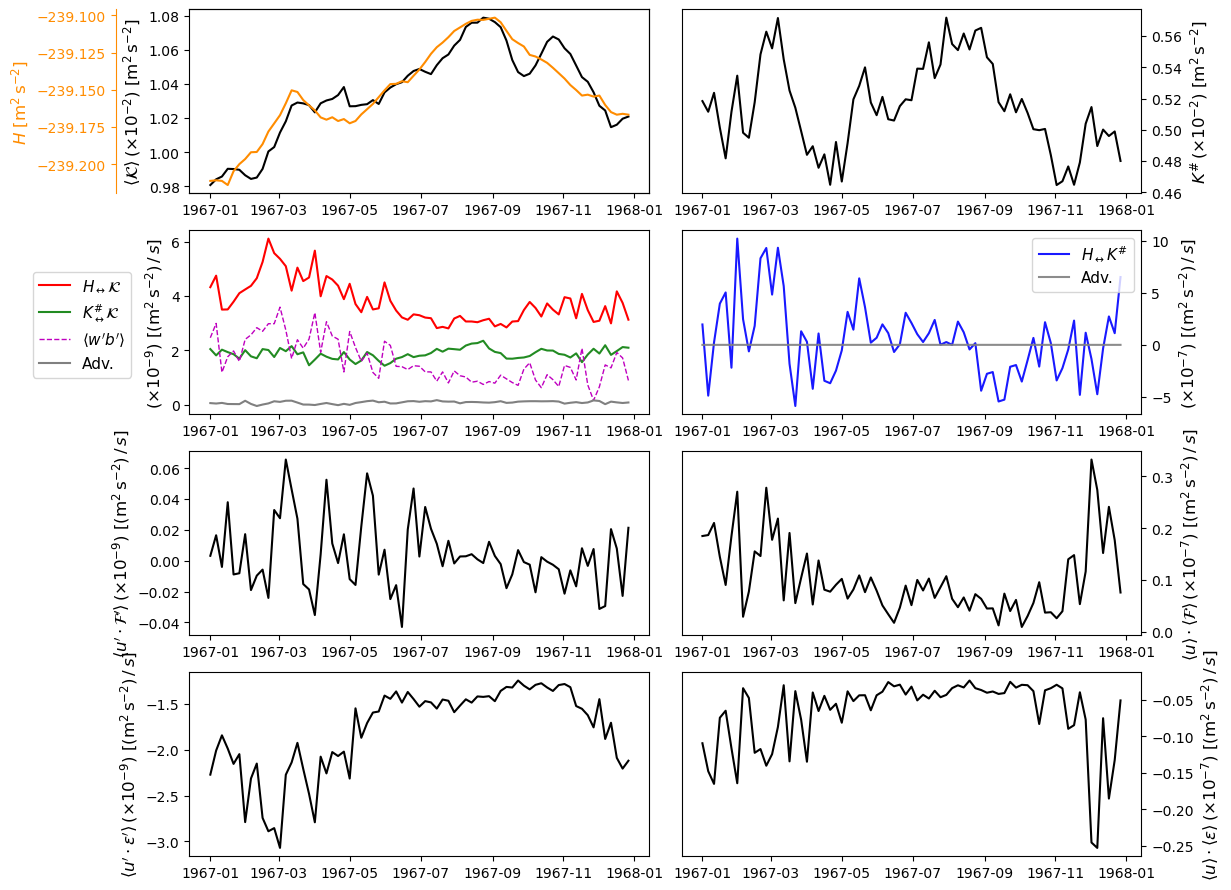

In [60]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(17,11))
# fig.set_tight_layout(True)
ax1 = axes[0,0]
ax3 = axes[1,0]
ax5 = axes[2,0]
ax7 = axes[3,0]
ax11 = ax1.twinx()
ax2 = axes[0,1]
ax4 = axes[1,1]
ax6 = axes[2,1]
ax8 = axes[3,1]

ax11.spines["left"].set_position(("axes", -.16))
ax11.spines["left"].set_visible(True)
# ax51.spines["left"].set_position(("axes", -.145))
# ax51.spines["left"].set_visible(True)

ax2.plot(time, dsE.MKE*1e2, c='k', label=r"$K^\#$")
ax1.plot(time, dse.EKE*1e2, 'k', label=r"$\langle\mathcal{K}\rangle$")
ax11.plot(time, dsh.H, 'darkorange', label=r"$D^\#$")

ax4.plot(time, dsWB.WB*1e7, c='b', alpha=.9, label=r"$H_\leftrightarrow K^\#$")
ax3.plot(time, dsH_.H_*1e9, 'r', label=r"$H_\leftrightarrow\mathcal{K}$")
ax3.plot(time, -dss.ShProd*1e9, c='forestgreen', label=r"$K^\#_\leftrightarrow\mathcal{K}$")
ax3.plot(time, dswb.wb*1e9, 'm--', lw=1, label=r"$\langle w'b'\rangle$")
ax4.plot(time, (dsA.advec-dsk.Kk-dss.ShProd)*1e7, c='grey', alpha=.9, ls='-', label=r"Adv.")
ax3.plot(time, (dsa.advec+dss.ShProd)*1e9, c='grey', ls='-', label=r"Adv.")

# ax5.plot(time, dst.TEND/86400*1e9, 'k', label=r"$\langle\mathcal{K}_t\rangle$")
# ax6.plot(time, dsT.TEND/86400*1e8, c='b', label=r"$K^\#_t$")
ax5.plot(time, dsf.forc*1e9, 'k-', label=r"Forc.")
ax7.plot(time, dsd.diss*1e9, 'k', label=r"Diss.")
ax6.plot(time, dsF.forc*1e7, c='k', ls='-', label=r"Forc.")
ax8.plot(time, dsD.diss*1e7, c='k', label=r"Diss.")

ax2.set_ylabel(r"$K^\#\, (\times 10^{-2})$ [m$^2\,$s$^{-2}$]", fontsize=12)
ax1.set_ylabel(r"$\langle\mathcal{K}\rangle\, (\times 10^{-2})$ [m$^2\,$s$^{-2}$]", 
               fontsize=12)
ax11.set_ylabel(r"$H$ [m$^2\,$s$^{-2}$]", fontsize=12)
ax3.set_ylabel(r"$(\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax4.set_ylabel(r"$(\times 10^{-7})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
# ax5.set_ylabel(r"$\langle\mathcal{K}_t\rangle\, (\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
#                fontsize=13)
# ax6.set_ylabel(r"$K^\#_t\, (\times 10^{-8})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
#                fontsize=13)
# ax6.set_ylabel(r"Dissip. $(\times 10^{-10})$ [(m$^2\,$s$^{-2})\, /\, s$]", fontsize=13)
ax7.set_ylabel(r"$\langle u'\cdot\epsilon'\rangle\, (\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax8.set_ylabel(r"$\langle u\rangle\cdot\langle\epsilon\rangle\, (\times 10^{-7})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax5.set_ylabel(r"$\langle u'\cdot\mathcal{F}'\rangle\, (\times 10^{-9})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)
ax6.set_ylabel(r"$\langle u\rangle\cdot\langle\mathcal{F}\rangle\, (\times 10^{-7})$ [(m$^2\,$s$^{-2})\, /\, s$]", 
               fontsize=12)

ax2.yaxis.tick_right()
ax4.yaxis.tick_right()
ax6.yaxis.tick_right()
ax8.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.set_label_position("right")
ax6.yaxis.set_label_position("right")
ax8.yaxis.set_label_position("right")
ax11.spines['left'].set_color('darkorange')
ax11.tick_params(axis='y', colors='darkorange')
ax11.yaxis.label.set_color('darkorange')
ax11.yaxis.set_label_position('left')
ax11.yaxis.set_ticks_position('left')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y', colors='k')
ax2.yaxis.label.set_color('k')
ax4.spines['right'].set_color('k')
ax4.tick_params(axis='y', colors='k')
ax4.yaxis.label.set_color('k')
# ax51.spines['left'].set_color('lightseagreen')
# ax51.tick_params(axis='y', colors='lightseagreen')
# ax51.yaxis.label.set_color('lightseagreen')
# ax51.yaxis.set_label_position('left')
# ax51.yaxis.set_ticks_position('left')
ax6.spines['right'].set_color('k')
ax6.tick_params(axis='y', colors='k')
ax6.yaxis.label.set_color('k')
ax8.spines['right'].set_color('k')
ax8.tick_params(axis='y', colors='k')
ax8.yaxis.label.set_color('k')

# ax11.legend(loc='center left', fontsize=12)
# ax2.legend(loc='lower right', fontsize=12)
# ax1.legend(loc='upper left', fontsize=12)
ax4.legend(loc='upper right', fontsize=11)
# ax4.legend(bbox_to_anchor=(1.37, .35), loc='lower right', 
#            borderaxespad=0., fontsize=11)
# ax3.legend(loc='lower left', fontsize=11)
ax3.legend(bbox_to_anchor=(-.34, .2), loc='lower left', 
           borderaxespad=0., fontsize=11)
# ax5.legend(loc='upper left', fontsize=12)
# ax6.legend(loc='upper right', fontsize=12)
# ax7.legend(bbox_to_anchor=(.015, .7), loc='center left', 
#            borderaxespad=0., fontsize=12)
# ax7.legend(loc='lower left', fontsize=12)
# ax8.legend(loc='center right', fontsize=12)

fig.subplots_adjust(right=.78, left=.22, wspace=.07, hspace=.2)

plt.savefig(op.join(savedir,'Figures/EC_timeseries_gyre.pdf'))